In [21]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative

In [22]:
metaserieses = [5, 5]
serieses = [1, 2]

series_names = None
# series_names = {
#     # 1: "IPA-accuracy",
#     2: "IPA",
#     # 3: "IPA-cost",
#     4: "FA2-high",
#     # 5: "FA2-high",
#     # 6: "RIM-low",
#     7: "RIM-high",
# }

series_paths = {
    series: os.path.join(
        FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series)
    )
    for series, metaseries in zip(serieses, metaserieses)
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [23]:
series_paths

{1: '/home/cc/malleable_scaler/data/results/final/metaseries/5/series/1',
 2: '/home/cc/malleable_scaler/data/results/final/metaseries/5/series/2'}

In [24]:
loaders

{1: <experiments.utils.parser.AdaptationParser at 0x7f8159449070>,
 2: <experiments.utils.parser.AdaptationParser at 0x7f81591f8f70>}

In [25]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 1 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 1,
    'allocation_mode': 'base',
    'alpha': 2,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 16,
    'benchmark_duration': 1,
    'central_queue': True,
    'cpu_cap': 16,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 1,
    'initial_active_model': ['yolov5n'],
    'initial_batch': [1],
    'initial_cpu_allocation': [1],
    'initial_replica': [1],
    'latency_margin': 0,
    'logs_enabled': True,
    'lowest_model_accuracy': 0,
    'metadata': 'check on lower load=40, multiplier=0.9, duration=10min',
    'metaseries': 5,
    'minikube_ip': '192.168.49.2',
    'mode': 'exponential',
    'model_name': ['yolo'],
    'monitoring_duration': 2,
    'nodes': [   {   'cpu_request': '16',
                     'data_type': 'image',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
 

In [26]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)
adaptation_logs

{1: {'timesteps': {'0': {'config': {'yolo': {'replicas': 1,
      'cpu': 16,
      'batch': '1',
      'latency': 0}},
    'time_interval': 0,
    'sla': 0,
    'predicted_load': 0},
   '1': {'config': {'yolo': {'replicas': 1,
      'cpu': 16,
      'batch': '1',
      'latency': 1}},
    'time_interval': 1,
    'sla': 0.0,
    'predicted_load': 40},
   '2': {'config': {'yolo': {'replicas': 1,
      'cpu': 16,
      'batch': '1',
      'latency': 1}},
    'time_interval': 2,
    'sla': 0.0,
    'predicted_load': 40},
   '3': {'config': {'yolo': {'replicas': 1,
      'cpu': 16,
      'batch': '1',
      'latency': 1}},
    'time_interval': 3,
    'sla': 0.0,
    'predicted_load': 40},
   '4': {'config': {'yolo': {'replicas': 1,
      'cpu': 16,
      'batch': '1',
      'latency': 1}},
    'time_interval': 4,
    'sla': 0.0,
    'predicted_load': 40},
   '5': {'config': {'yolo': {'replicas': 1,
      'cpu': 16,
      'batch': '1',
      'latency': 1}},
    'time_interval': 5,
    'sla':

In [27]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )
series_changes

{1: {'time_interval': [],
  'accuracy_objective': [],
  'resource_objective': [],
  'batch_objective': [],
  'objective': [],
  'monitored_load': [],
  'predicted_load': [],
  'sla': [0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   932.0,
   928.0,
   928.0,
   922.0,
   906.0,
   862.0,
   864.0,
   892.0,
   884.0,
   916.0,
   942.0,
   930.0,
   927.0,
   928.0,
   936.0,
   934.0,
   944.0,
   925.0,
   933.0,
   920.0,
   912.0,
   884.0,
   933.0,
   915.0,
   901.0,
   897.0,
   928.0,
   932.0,
   923.0,
   914.0,
   875.0,
   873.0,
   857.0,
   893.0,
   911.0,
   910.0,
   863.0,
   827.0,
   819.0,
   917.0,
   932.0,
   939.0,
   930.0,
   953.0,
   950.0,
   924.0,
   905.0,
   952.0,
   909.0,
   914.0,
   891.0,
   916.0,
   919.0,
   949.0,
   930.0,
   956.0,
   948.0,
   948.0,
   937.0,
   950.0,
   935.0,
   913.0,
   876.0,
   900.0,
   885.0,
   885.0,
   900.0,
   931.0,
   909.0,
   863.0,
   867.0,
   775.0,
   936.0,
   940.0,
   931.0,
   902.0,
   954.0,
   

## Replica Changes
1. Total
2. Per node

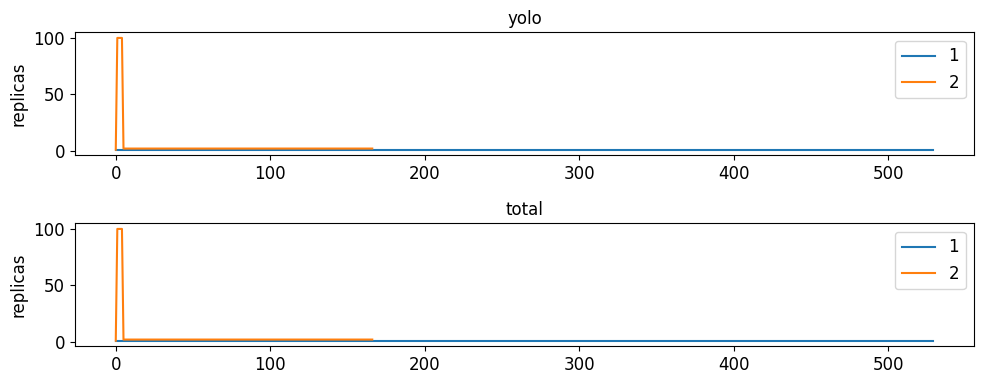

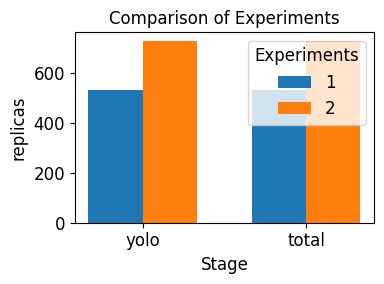

{1: {'yolo': [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,

In [28]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]
    # draw_temporal(replica_changes[series], adaptation_intervals[series])
ylabel = "replicas"
draw_temporal(
    replica_changes, adaptation_intervals, ylabel=ylabel, multiple_experiments=True
)
draw_cumulative(replica_changes, multiple_experiments=True, ylabel=ylabel)
replica_changes

## Per Container Core changes
1. Total
2. Per Node

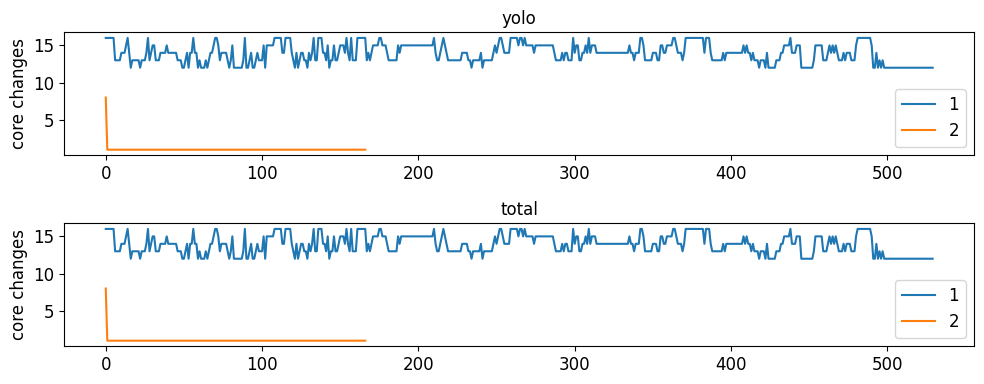

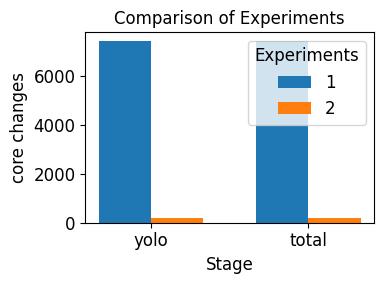

In [29]:
sla_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    sla_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        sla_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    sla_changes[series]["total"] = [
        sum(x) for x in zip(*sla_changes[series].values())
    ]
    # draw_temporal(core_changes[series])
ylabel = "core changes"
draw_temporal(
    sla_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)

draw_cumulative(
    sla_changes, multiple_experiments=True, ylabel=ylabel, series_names=series_names
)

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

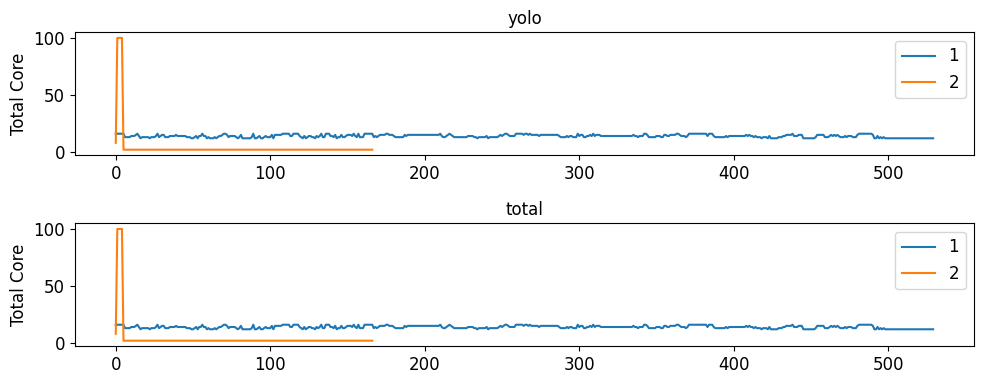

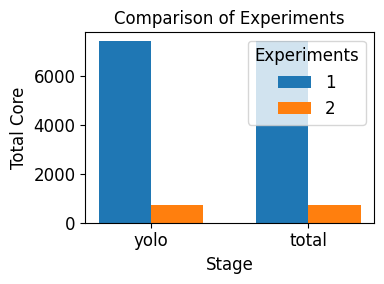

In [30]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], sla_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()
    # draw_temporal(total_core_changes[series])
ylabel = "Total Core"
draw_temporal(
    total_core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
draw_cumulative(
    total_core_changes,
    multiple_experiments=True,
    ylabel=ylabel,
    series_names=series_names,
)

## Batching Changes

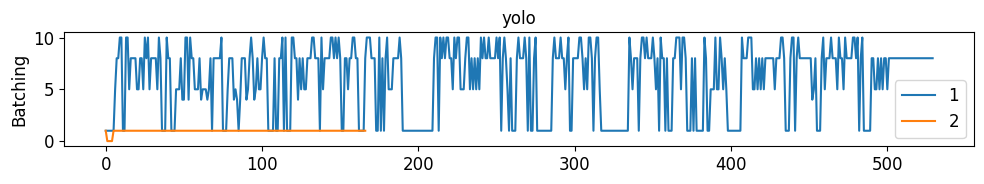

In [31]:
sla_changes = {}
for series in serieses:
    sla_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        sla_changes[series][node_name] = metrics["batch"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    # batching_changes['total'] = [sum(x) for x in zip(*batching_changes.values())]
    # draw_temporal(batching_changes[series])
ylabel = "Batching"
draw_temporal(
    sla_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(batching_changes, multiple_experiments=True, ylabel=ylabel)

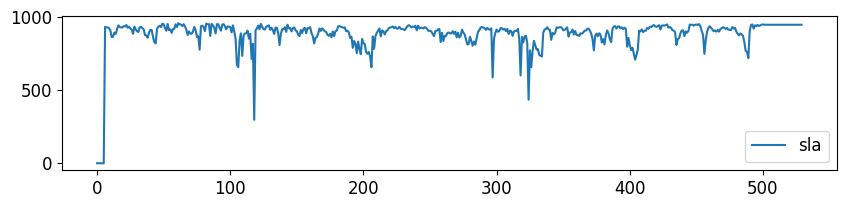

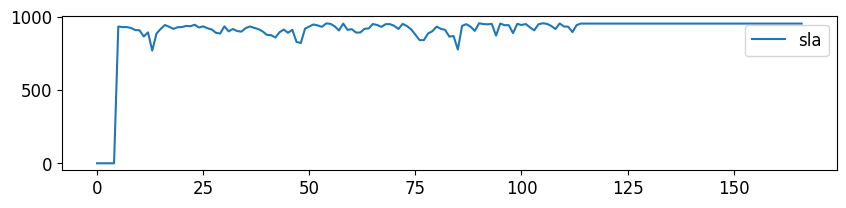

In [32]:
sla_changes = {}
for series in serieses:
    sla = series_changes[series]["sla"]
    sla_x = [x for x in range(0, len(sla))]
    plt.figure(figsize=(10, 2))
    plt.plot(sla_x, sla, label="sla")
    plt.legend()
    plt.show()

## Expected Latency

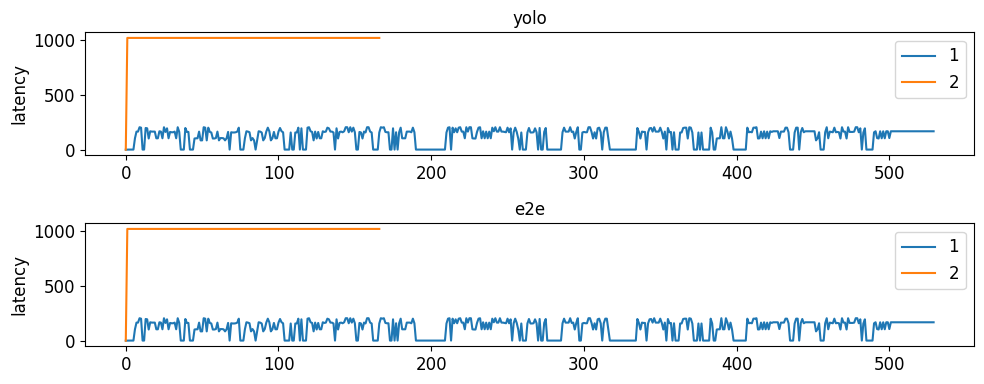

In [33]:
latency_changes = {}
for series in serieses:
    latency_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        latency_changes[series][node_name] = metrics["latency"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    latency_changes[series]["e2e"] = [
        sum(x) for x in zip(*latency_changes[series].values())
    ]
    # draw_temporal(latency_changes[series])
ylabel = "latency"
draw_temporal(
    latency_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(latency_changes, multiple_experiments=True, ylabel=ylabel)

# Real Latencies

## Maeseured p99 Latency


In [34]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[
            series
        ].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

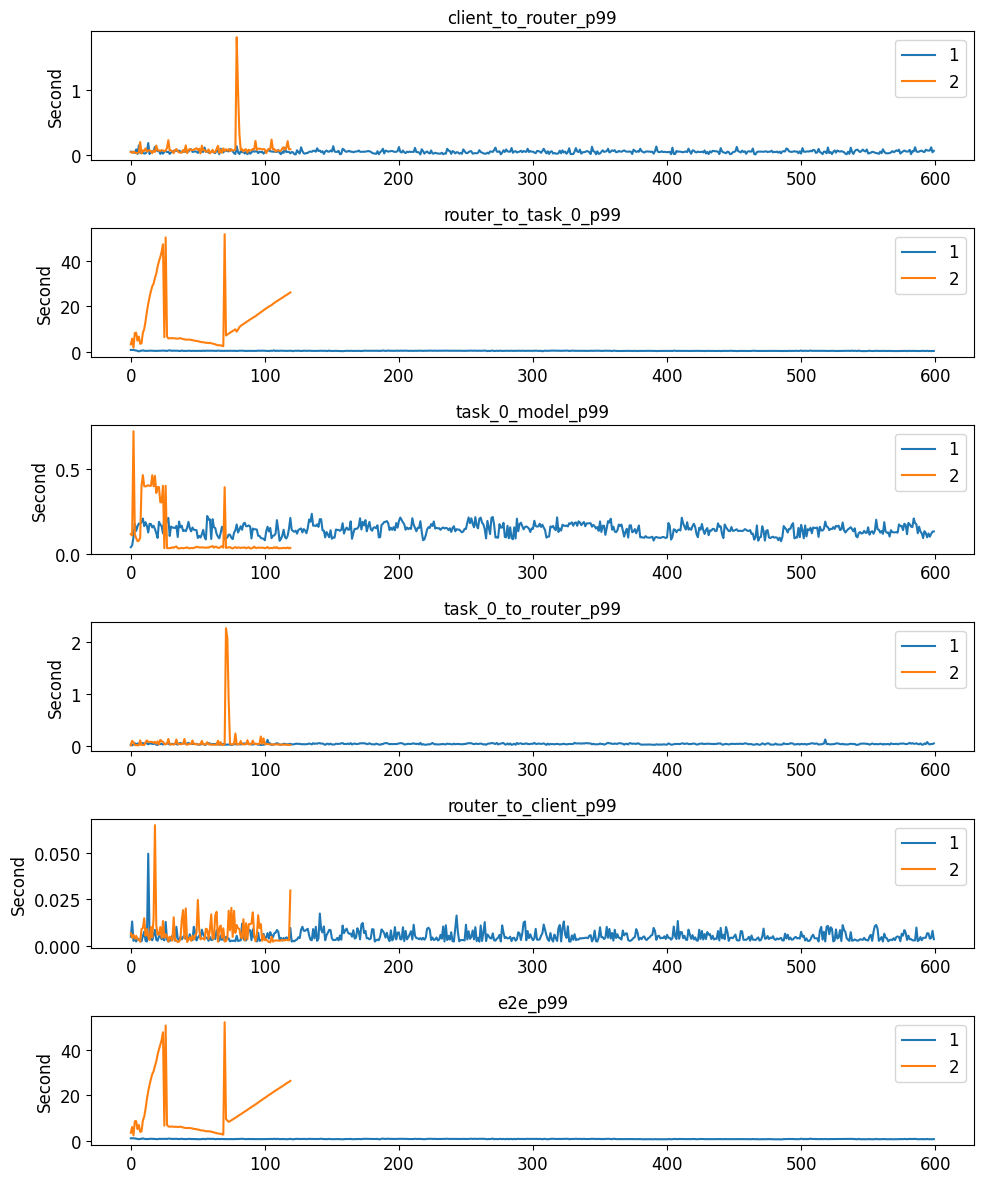

In [35]:
if not all(simulation_modes.values()):
    metric = "p99"  # [min, max, p99]
    metrics_all = {}
    for series in serieses:
        # print(50 * "-" + f" {series} " + 50 * "-")
        if not simulation_modes[series]:
            metric_columns = list(
                filter(lambda col: metric in col, per_second_results[series].columns)
            )
            metrics_all[series] = per_second_results[series][metric_columns]
            # metrics_all[series][f"{metric}_e2e"] = metrics_all[series].sum(axis=1).to_list()
            metrics_all[series] = metrics_all[series].to_dict(orient="list")
            # draw_temporal(metrics_all[series])
    ylabel = "Second"
    draw_temporal(metrics_all, multiple_experiments=True, ylabel=ylabel)
    # draw_cumulative(metrics_all, multiple_experiments=True, ylabel=ylabel)

# Every point a change was triggered

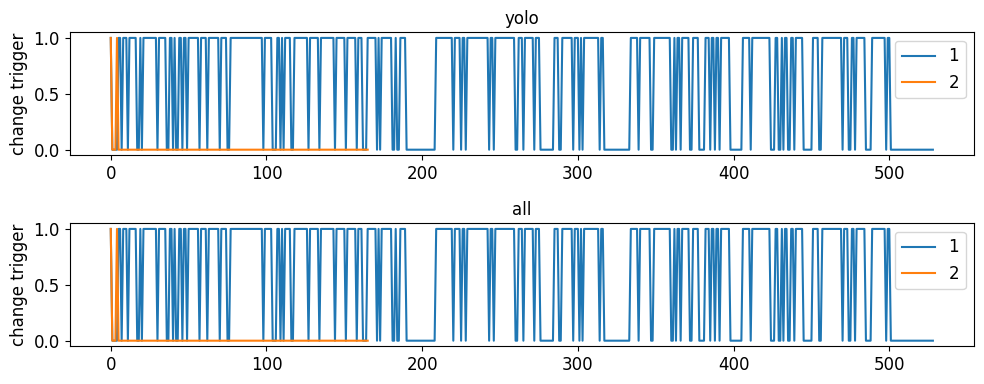

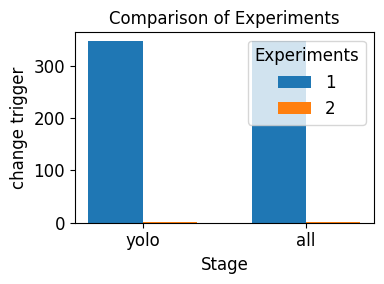

In [36]:
change_trigger = {}
for series in serieses:
    change_trigger[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    change_trigger[series] = loader.points_with_change(
        adaptation_log=adaptation_logs[series]
    )
    change_trigger[series]["all"] = [
        any(x) for x in zip(*change_trigger[series].values())
    ]
    # draw_temporal(change_trigger[series], adaptation_interval=adaptation_intervals[series])
ylabel = "change trigger"
draw_temporal(
    change_trigger, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
draw_cumulative(change_trigger, multiple_experiments=True, ylabel=ylabel)

## timeouts

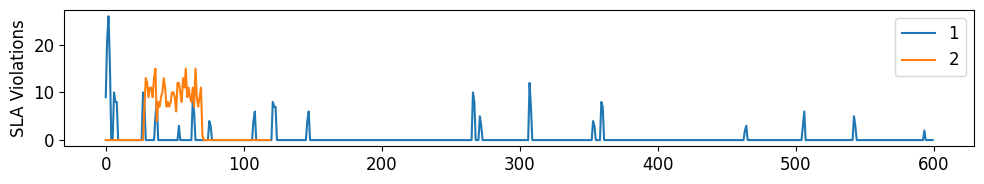

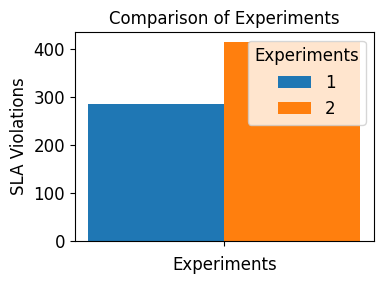

In [37]:
import numpy as np

if not all(simulation_modes.values()):
    ylabel = "SLA Violations"
    xlabel = "Experiments"
    timeout_dics = {}
    for series in serieses:
        # print(50 * "-" + f" {series} " + 50 * "-")
        if not simulation_modes[series]:
            timeout_dics[series] = {
                "": (
                    np.array(timeout_per_second[series])
                ).tolist()
            }
            # draw_temporal(timeout_dics[series])
            # print(f"{sum(timeout_per_second[series])} out of {sum(sent_loads[series])}")
    draw_temporal(timeout_dics, multiple_experiments=True, ylabel=ylabel)
    draw_cumulative(
        timeout_dics,
        multiple_experiments=True,
        ylabel=ylabel,
        series_names=series_names,
        xlabel=xlabel,
    )

In [38]:
for series in serieses:
    print(50 * "-" + f" {series} " + 50 * "-")
    for key, value in series_changes[series].items():
        if key == "nodes":
            for node_name, all_configs in value.items():
                print(f"node: {node_name}\n")
                for config_name, config_values in all_configs.items():
                    print(f"{config_name}: {config_values}")

-------------------------------------------------- 1 --------------------------------------------------
node: yolo

cpu: [16, 16, 16, 16, 16, 16, 13, 13, 13, 13, 14, 14, 14, 15, 16, 14, 12, 13, 13, 13, 13, 13, 12, 13, 13, 13, 14, 16, 13, 14, 15, 15, 13, 13, 13, 14, 14, 14, 14, 15, 14, 14, 14, 14, 14, 14, 13, 13, 13, 12, 12, 13, 14, 12, 14, 14, 16, 14, 14, 12, 13, 12, 12, 12, 13, 12, 13, 14, 14, 15, 16, 16, 15, 13, 14, 14, 14, 14, 13, 12, 13, 15, 12, 12, 12, 12, 12, 12, 13, 16, 12, 12, 13, 14, 12, 12, 13, 14, 13, 13, 13, 15, 12, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 14, 14, 16, 16, 16, 16, 14, 13, 12, 14, 12, 13, 14, 14, 13, 13, 12, 14, 13, 14, 16, 13, 13, 16, 16, 16, 14, 14, 13, 15, 12, 13, 13, 15, 13, 13, 14, 15, 15, 15, 14, 16, 14, 13, 16, 13, 13, 13, 16, 16, 16, 16, 16, 16, 13, 14, 13, 14, 15, 15, 15, 15, 16, 16, 15, 15, 15, 14, 13, 13, 13, 13, 13, 13, 15, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 14, 13, 13, 14, 15, 16, 15, 14, 13

In [39]:
for series in serieses:
    print(50 * "-" + f" {series} " + 50 * "-")
    for key, value in series_changes[series].items():
        if key == "nodes":
            for node_name, all_configs in value.items():
                print(f"node variants: {node_name}\n")
                print(f"variants: {set(all_configs['variant'])}")

-------------------------------------------------- 1 --------------------------------------------------
node variants: yolo

variants: set()
-------------------------------------------------- 2 --------------------------------------------------
node variants: yolo

variants: set()
